### import packages

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import gc
import matplotlib.pyplot as plt
%matplotlib inline  
import seaborn as sns

### download data sets

Visit: https://www.kaggle.com/c/allstate-claims-severity/data <br\>
You need to accept the competition rules in order to download the datasets:
train.csv
test.csv

### read data + lexical encoding

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

test['loss'] = np.nan
data = pd.concat([train, test])
categorical_list = list(data.select_dtypes(include=['object']).columns)

# lexical encoding
for column in categorical_list:
    data[column] = pd.factorize(data[column].values, sort=True)[0]

train = data[data['loss'].notnull()]
test  = data[data['loss'].isnull()]

test_id = test['id']
y_train = np.log(train['loss'] + 200)    #  log(y + 200) transformation is applied to y
del train['id']
del train['loss'] 
del test['id']
del test['loss']

### take a look at the shape of data

In [4]:
print(train.shape)      # X_train
print(test.shape)       # X_test
print(y_train.shape)    # y_train

np.mean(y_train)        # used as base_score

(188318, 130)
(125546, 130)
(188318,)


7.799837008871419

### parameter tuning, convert dataframe to DMatrix

In [5]:
X_y_train = xgb.DMatrix(data=train, label=y_train)
X_test = xgb.DMatrix(data=test)

In [6]:
params = {
        'base_score':8,
        'min_child_weight': 1,
        'eta':  0.005,
        'colsample_bytree': 0.5,
        'max_depth': 12,
        'subsample': 0.7,
        'alpha': 1,
        'gamma': 1,
        'seed': 2017,
        'objective'   :'reg:linear',
        'eval_metric' :'rmse'
        }

### clean momory (optional; do it if your computer memory size is small)

In [7]:
# Delete to save momory
del train
del test
gc.collect()

34

### cross validation to decide when to stop & tune parameters

In [9]:
model = xgb.cv(params=params,  
                dtrain=X_y_train, 
                num_boost_round=20,
                nfold=5,
                verbose_eval = True,
                seed =1)

[0]	train-rmse:0.756436+0.000819041	test-rmse:0.756499+0.00329978
[1]	train-rmse:0.754562+0.000850815	test-rmse:0.754693+0.00326685
[2]	train-rmse:0.752692+0.000890147	test-rmse:0.752886+0.00323106
[3]	train-rmse:0.750896+0.000808201	test-rmse:0.751165+0.00329603
[4]	train-rmse:0.749072+0.000761642	test-rmse:0.74941+0.00335772
[5]	train-rmse:0.747338+0.000785196	test-rmse:0.747744+0.00335287
[6]	train-rmse:0.745502+0.00069703	test-rmse:0.745985+0.00342583
[7]	train-rmse:0.743728+0.000766653	test-rmse:0.744281+0.00333041
[8]	train-rmse:0.742031+0.000771156	test-rmse:0.742659+0.00330182
[9]	train-rmse:0.740377+0.000675791	test-rmse:0.741074+0.00338972
[10]	train-rmse:0.738625+0.000691948	test-rmse:0.739395+0.00335865
[11]	train-rmse:0.736952+0.000633242	test-rmse:0.737786+0.00340011
[12]	train-rmse:0.735268+0.000611624	test-rmse:0.736176+0.0034021
[13]	train-rmse:0.733598+0.000675172	test-rmse:0.734586+0.00331469
[14]	train-rmse:0.731899+0.000712591	test-rmse:0.732959+0.00328943
[15]	tra

### train model, submit prediction file

In [11]:
model = xgb.train(params=params,  
                  dtrain=X_y_train, 
                  num_boost_round=250)

In [ ]:
y_test = np.exp(model.predict(X_test)) - 200     # Use exp(y) - 200 to recover original values

submission = pd.DataFrame({'id':test_id, 'loss':y_test})
submission.to_csv('submission.csv', index=False)

### plot feature importance
(make sure you have the newset version of xgboost)

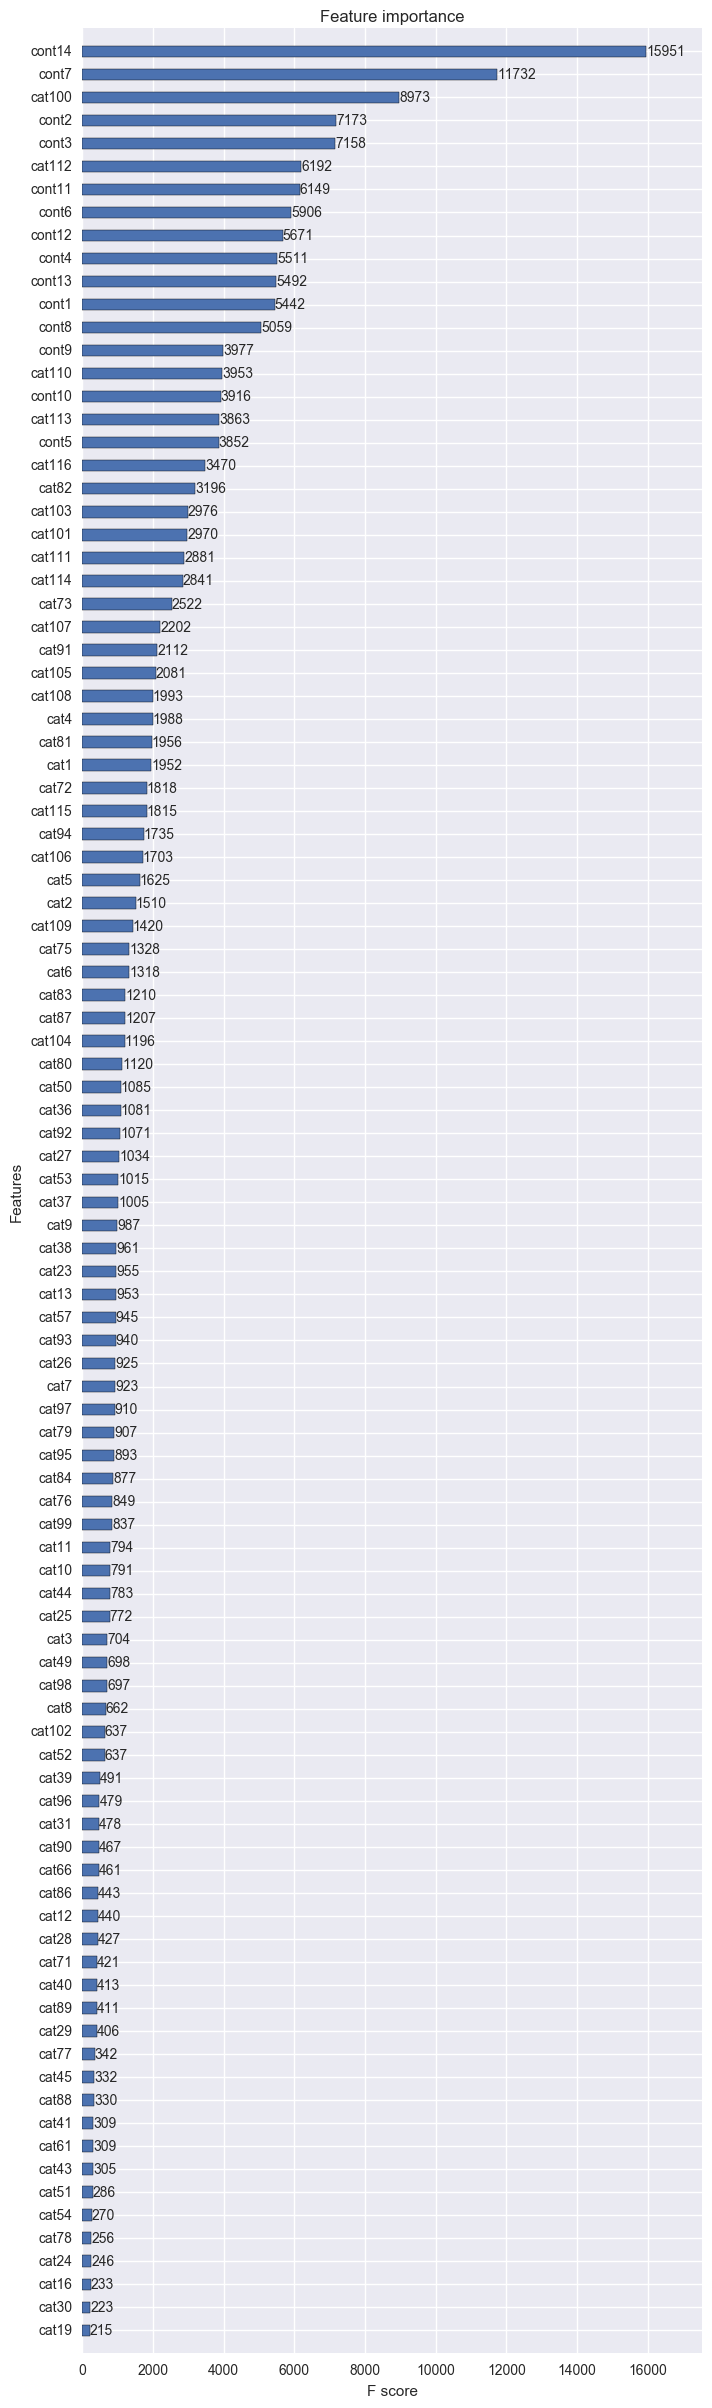

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(8,30))
a,b =xgb.plot_importance(model, max_num_features=100, height=0.5, ax=ax)